<h2><b>Họ và tên:</b> Phan Nguyễn Thành Nhân</h2>
<h2><b>MSSV:</b> 19521943</h2>
<h2><b>Lớp:</b> CS116.M12.KHCL</h2>

# Import library

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import Tensor
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input, Add
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Get MNIST dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create MiniResNet

In [5]:
def residual_blk(x: Tensor, num_channels: int, use_1x1conv: bool=False, strides: int=1, kernel_size: int=3) -> Tensor:
  conv = Conv2D(filters=num_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)
  bn = BatchNormalization()(conv)
  relu = ReLU()(bn)
  conv = Conv2D(filters=num_channels, kernel_size=kernel_size, strides=strides, padding='same')(relu)
  bn = BatchNormalization()(conv)

  if use_1x1conv:
    x = Conv2D(filters=num_channels, kernel_size=1, strides=strides, padding='same')(x)

  add = Add()([x, bn])
  result = ReLU()(add)

  return result

In [6]:
def resnet(inputs):
  conv = Conv2D(8, kernel_size=3, strides=1, padding='same')(inputs)
  bn = BatchNormalization()(conv)
  relu = ReLU()(bn)
  max_pooling = MaxPooling2D(strides=2)(relu)

  blk = residual_blk(max_pooling, 8)

  conv = Conv2D(16, kernel_size=3, strides=2, padding='same')(blk)

  blk = residual_blk(conv, 16)

  average_pooling = AveragePooling2D()(blk)
  flatten = Flatten()(average_pooling)
  dense = Dense(400, activation='relu')(flatten)
  outputs = Dense(10, activation='softmax')(dense)

  return outputs

In [7]:
def initialize():
  inputs = Input(shape=(28,28,1))
  outputs = resnet(inputs)

  net = Model(inputs, outputs)

  net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return net

In [8]:
net = initialize()
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 8)    80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 28, 28, 8)    0           ['batch_normalization[0][0]']

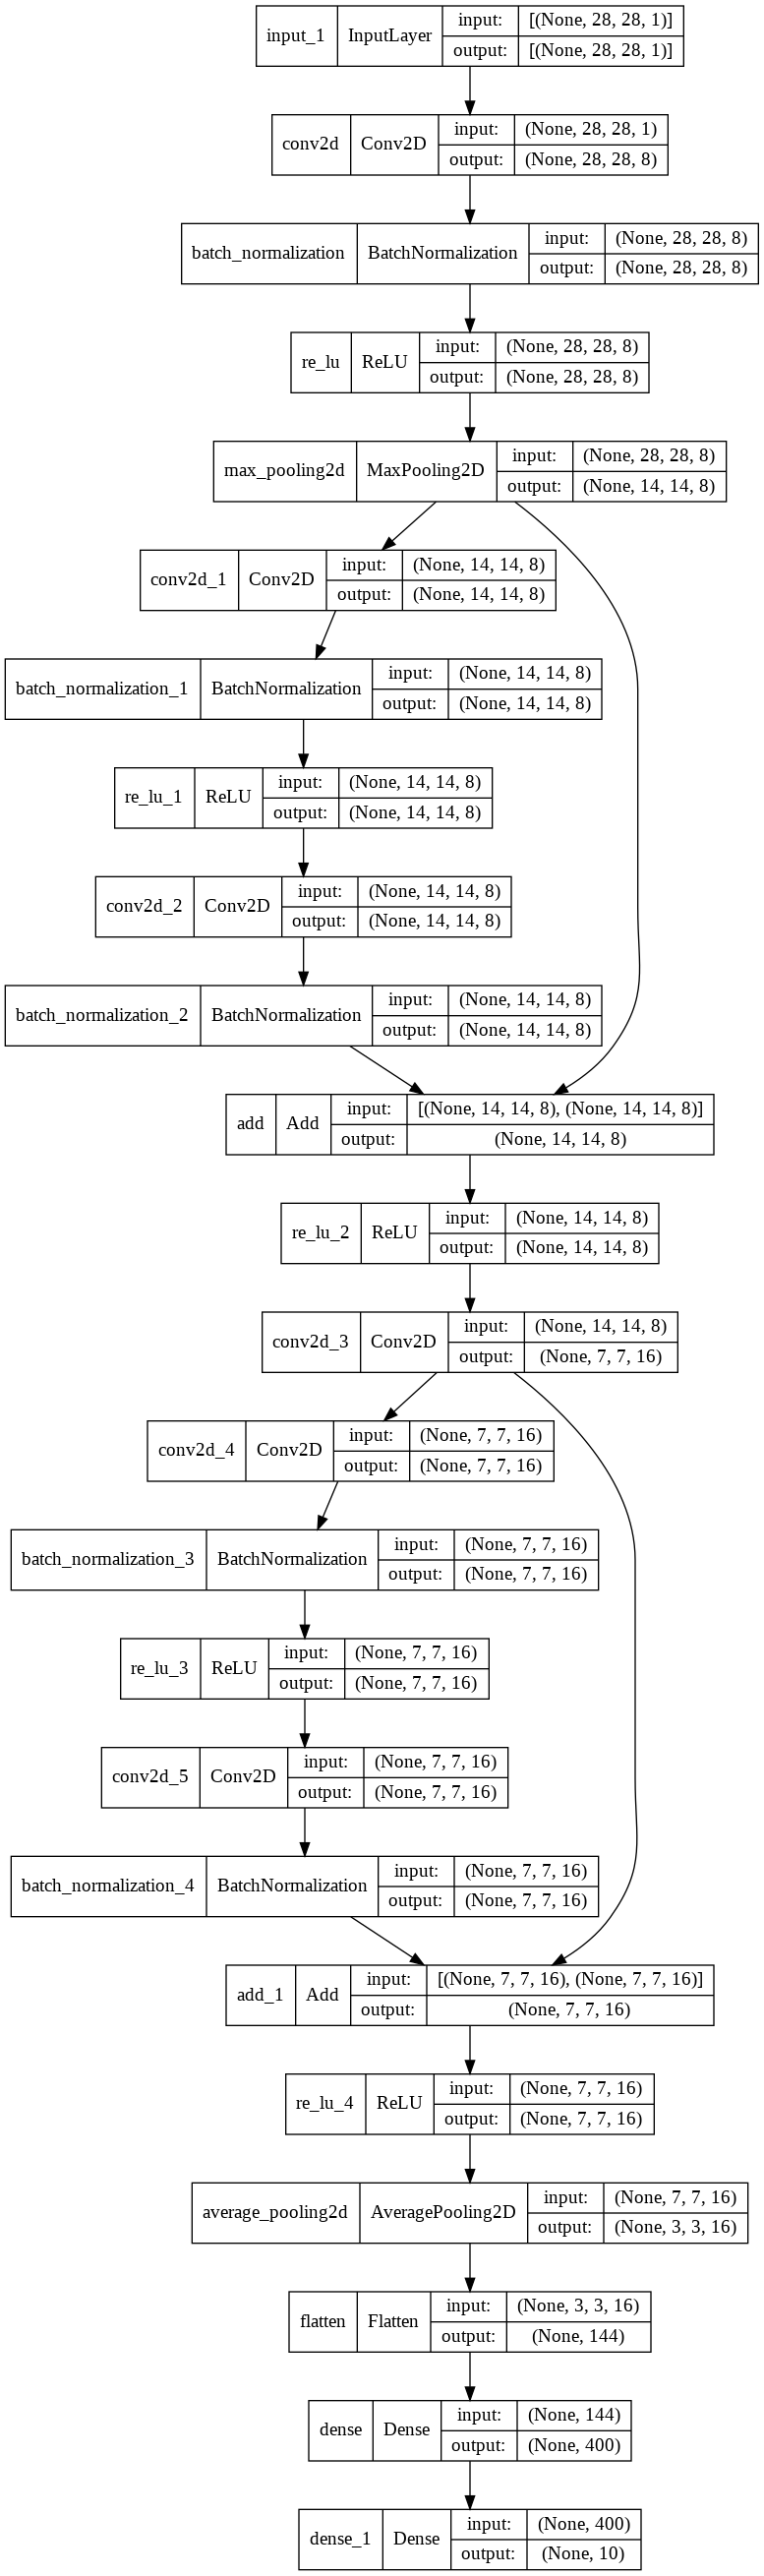

In [9]:
keras.utils.plot_model(net, 'architecture.png', show_shapes=True)

# Train

In [10]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [11]:
history_net = net.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1500/1500 [==============================] - 55s 8ms/step - loss: 0.1567 - accuracy: 0.9501 - val_loss: 0.0623 - val_accuracy: 0.9808
Epoch 2/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0574 - accuracy: 0.9823 - val_loss: 0.0541 - val_accuracy: 0.9833
Epoch 3/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0440 - accuracy: 0.9854 - val_loss: 0.0414 - val_accuracy: 0.9874
Epoch 4/100
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0340 - accuracy: 0.9885 - val_loss: 0.0450 - val_accuracy: 0.9867
Epoch 5/100
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0610 - val_accuracy: 0.9825
Epoch 6/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.0430 - val_accuracy: 0.9883
Epoch 7/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.0454 -

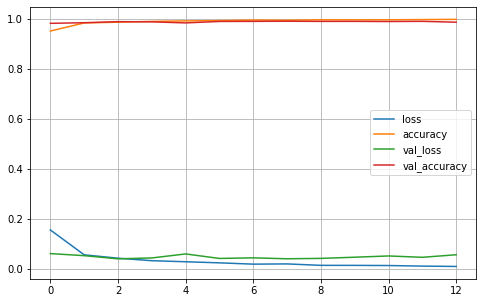

In [13]:
pd.DataFrame(history_net.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Predict and evaluate model

In [23]:
def draw_cf_matrix(label, pred):
  cf_matrix = confusion_matrix(label, pred)
  plt.figure(figsize=(10,8))
  ax = plt.subplot()
  sns.heatmap(cf_matrix, annot=True, ax = ax, fmt='g', cmap='Greens')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
  ax.yaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
  cf_matrix

In [15]:
y_pred_prob = net.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis= 1)
print(y_pred)

[7 2 1 ... 4 5 6]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



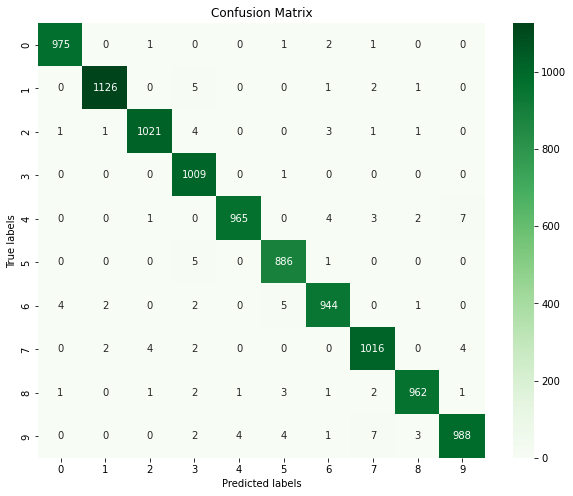

In [24]:
draw_cf_matrix(y_test.reshape(-1,1), y_pred)
print(classification_report(y_test.reshape(-1,1), y_pred))